In [5]:
from __future__ import print_function
import numpy as np
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torchvision
import sys 
import os
from torch.utils.data import DataLoader, Subset
sys.path.append(os.path.abspath("/Users/stefr/Documents/GitHub/Thesis/Methods"))


In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()  # Pass class name 'VAE' and instance 'self'
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, beta=0.02):  # Add 'beta' as a parameter
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)

        # Calculate the reconstruction loss (MSE)
        reconstruction_loss = nn.functional.mse_loss(x_hat, x.view(-1, 784), reduction='sum')

        # Calculate the KL divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Combine the reconstruction loss and KL divergence with 'beta'
        total_loss = reconstruction_loss + beta * kl_divergence

        return x_hat, mu, logvar, total_loss

In [44]:
def encode_data_and_save_labels(model, data_loader, num_samples):
    encoded_data = []
    labels = []
    count = 0

    for batch_data, batch_labels in data_loader:
        for data, label in zip(batch_data, batch_labels):
            label = label.item()  # Convert the label tensor to a scalar
            if label in [0,1,3,5,9] and count < num_samples:
                data = Variable(data.view(-1, 784))
                z_mean, _ = model.encode(data)
                encoded_data.append(z_mean[0].detach().numpy())
                labels.append(label)
                count += 1

    return np.array(encoded_data), labels

In [46]:
def create_filtered_mnist_data_loader(digits, batch_size):

    data_transform = transforms.Compose([transforms.ToTensor()])

    full_mnist_dataset = datasets.MNIST(
        root='./mnist_data',
        train=True,
        transform=data_transform,
        download=True
    )

    # Create a list of indices corresponding to the specified digits
    digit_indices = [i for i in range(len(full_mnist_dataset)) if full_mnist_dataset[i][1] in digits]

    # Create a Subset of the dataset with only the specified digits
    filtered_dataset = Subset(full_mnist_dataset, digit_indices)

    # Create a data loader for the filtered dataset
    data_loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

    return data_loader


In [3]:
model = VAE()  # Initialize an instance of your VAE model
model.load_state_dict(torch.load('./Model_state/vaeGoodtrain_50.pth'))

<All keys matched successfully>

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Encode the MNIST dataset
encoded_data = []
labels = []

In [9]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Encode the MNIST dataset
encoded_data = []
labels_list = []  # Use a different variable name for the list of labels

with torch.no_grad():
    for images, labels in dataloader:
        encoded_images, _, _ = model(images)
        encoded_data.append(encoded_images)
        labels_list.append(labels)  # Use a different variable name

encoded_data = torch.cat(encoded_data, dim=0).cpu().numpy()
labels = torch.cat(labels_list, dim=0).numpy()  # Now use labels_list for the list of labels


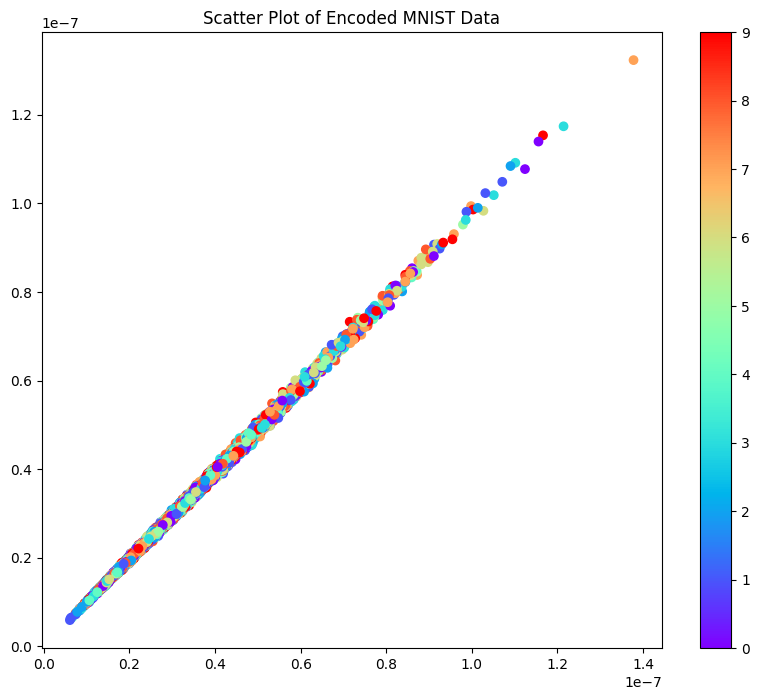

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(encoded_data[:, 0], encoded_data[:, 5], c=labels, cmap='rainbow')
plt.colorbar()
plt.title("Scatter Plot of Encoded MNIST Data")
plt.show()